In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'


sns.set(style="darkgrid") # Plot parameters defined globally
plt.style.use("seaborn-v0_8-dark")     

# Part IV: Evaluate Models
----
----

---
## CH16: Backtest Forecast Models 
---

The goal of time series forecasting is to make accurate predictions about the future. The fast and powerful methods that we rely on in machine learning, such as using train-test splits and k-fold cross-validation, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem. In this tutorial, you will discover how to evaluate machine learning models on time series data with Python. In the field of time series forecasting, this is called backtesting or hindcasting. After completing this tutorial, you will know:

- The limitations of traditional methods of model evaluation from machine learning and why evaluating models on out-of-sample data is required.
- How to create train-test splits and multiple train-test splits of time series data for model evaluation in Python.
- How walk-forward validation provides the most realistic evaluation of machine learning models on time series data.

Let’s get started.

### Model Evaluation:

How do we know how good a given model is? We could evaluate it on the data used to train it. This would be invalid. It might provide insight into how the selected model works, and even how it may be improved. But, any estimate of performance on this data would be optimistic, and any decisions based on this performance would be biased. Why?

It is helpful to take it to an extreme: A model that remembered the timestamps and value for each observation would achieve perfect performance. All real models we prepare will report a pale version of this result.

When evaluating a model for time series forecasting, we are interested in the performance of the model on data that was not used to train it. In machine learning, we call this unseen or out-of-sample data. We can do this by splitting up the data that we do have available. We use some to prepare the model and we hold back some data and ask the model to make predictions for that period. The evaluation of these predictions will provide a good proxy for how the model will perform when we use it operationally.

In applied machine learning, we often split our data into a train and a test set: the training set used to prepare the model and the test set used to evaluate it. We may even use k-fold cross-validation that repeats this process by systematically splitting the data into k groups, each given a chance to be a held out model.
These methods cannot be directly used with time series data. This is because they assume that there is no relationship between the observations, that each observation is independent. This is not true of time series data, where the time dimension of observations means that we cannot randomly split them into groups. Instead, we must split data up and respect the temporal order in which values were observed.
In time series forecasting, this evaluation of models on historical data is called backtesting. In some time series domains, such as meteorology, this is called hindcasting, as opposed to forecasting. We will look at three different methods that you can use to backtest your machine learning models on time series problems. They are:
1. Train-Test split that respect temporal order of observations.
2. Multiple Train-Test splits that respect temporal order of observations.
3. Walk-Forward Validation where a model may be updated each time step new data is received.

First, let’s take a look at a small, univariate time series data we will use as context to understand these three backtesting methods: the Sunspot dataset.

In this lesson, we will use the Monthly Sunspots dataset as an example. This dataset describes a monthly count of the number of observed sunspots for just over 230 years (1749-1983).

In [2]:
df = pd.read_csv('monthly-sunspots.csv', index_col = 0, header = 0, parse_dates=True)

df.head()

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


#### Train-Test Split:

You can split your dataset into training and testing subsets. Your model can be prepared on the training dataset and predictions can be made and evaluated for the test dataset. This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets. Depending on the amount of data you have available and the amount of data required, you can use splits of 50-50, 70-30 and 90-10. It is straightforward to split data in Python.

After loading the dataset as a Pandas Series, we can extract the NumPy array of data values. The split point can be calculated as a specific index in the array. All records up to the split point are taken as the training dataset and all records from the split point to the end of the list of observations are taken as the test set. Below is an example of this in Python using a split of 66-34.

In [3]:
ss_series = df.squeeze('columns')

X = ss_series.values

train_size = int(len(X)*0.66)

X_train, X_test  = X[:train_size], X[train_size:]

print(f"Total Observations: {len(X)}")
print(f"Training Observations: {len(X_train)}")
print(f"Test Observations: {len(X_test)}")

Total Observations: 2820
Training Observations: 1861
Test Observations: 959


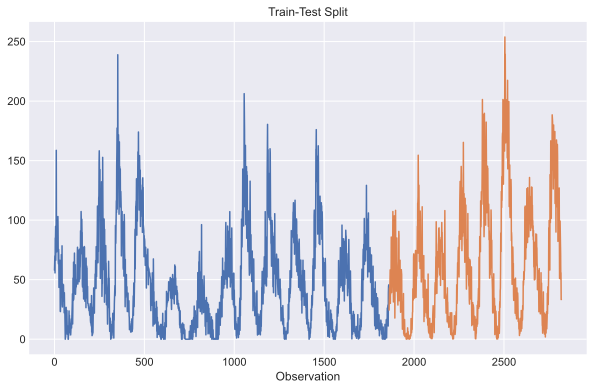

In [4]:
fig, axis = plt.subplots(figsize = (10,6))

axis.plot(X_train)
axis.plot([None for i in X_train]+ [x for x in X_test])

axis.set_xlabel('Observation')
axis.set_title('Train-Test Split')

axis.grid()

Using a train-test split method to evaluate machine learning models is fast. Preparing the data is simple and intuitive and only one model is created and evaluated. It is useful when you have a large amount of data so that both training and tests sets are representative of the original problem. Next, we will look at repeating this process multiple times.

#### Multiple Train-Test Splits:

We can repeat the process of splitting the time series into train and test sets multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data. We could do this manually by repeating the process described in the previous section with different split points.

Alternately, the scikit-learn library provides this capability for us in the `TimeSeriesSplit` object. You must specify the number of splits to create and the `TimeSeriesSplit` to return the indexes of the train and test observations for each requested split. The total number of training and test observations are calculated each split iteration (i) as follows:

$$ training_{-}{size} = i \times \frac{n_{-}{samples}}{n_{-}{splits} + 1} + n_{-}{samples}\, mod (n_{-}{splits} + 1)  $$

$$test_{-}{size} = \frac{n_{-}{samples}}{n_{-}{splits} + 1} $$

Where `n_samples` is the total number of observations and `n_splits` is the total number of splits. You can see from the formulas that the `training_size` is increasing at each split iterations labelled by `i` whereas the `test_size` stays constant. This means that performance statistics calculated on the predictions of each trained model will be consistent and can be combined and compared. It provides an apples-to-apples comparison.

What differs is the number of records used to train the model each split, offering a larger and larger history to work with. This may make an interesting aspect of the analysis of results.

In [5]:
def split_func(i, n_samples, n_splits):

    train_size = i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1)
    test_size = n_samples//(n_splits + 1)
    return train_size, test_size

If we perform `3` splits for the sunspot data set, using the formulas above we would expect: 

In [6]:
n_samples = len(X)
n_splits = 3

for i in range(1,4):

    print(f"Train-test size for Split {i}: {split_func(i,n_samples, n_splits)}")

Train-test size for Split 1: (705, 705)
Train-test size for Split 2: (1410, 705)
Train-test size for Split 3: (2115, 705)


In [7]:
# This expectation is matched by the TimeSeriesSplit function 

from sklearn.model_selection import TimeSeriesSplit

splits = TimeSeriesSplit(n_splits=3)

for train_index, test_index in splits.split(X):

  X_train = X[train_index]
  X_test = X[test_index]
  
  print(f"Total Observations: {len(X_train) + len(X_test)}")
  print(f"Training Observations: {len(X_train)}")
  print(f"Test Observations: {len(X_test)}")
  print("\n")

Total Observations: 1410
Training Observations: 705
Test Observations: 705


Total Observations: 2115
Training Observations: 1410
Test Observations: 705


Total Observations: 2820
Training Observations: 2115
Test Observations: 705




Text(0.5, 0.01, 'Observations')

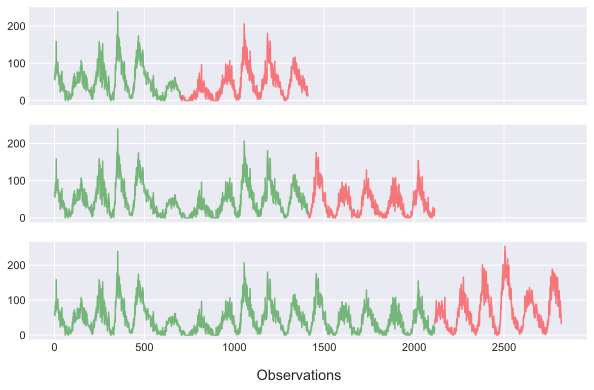

In [8]:
fig, axis = plt.subplots(3,1,figsize = (10,6), sharex=True)

index = 0
for train_index, test_index in splits.split(X):

    X_train = X[train_index]
    X_test = X[test_index]
    
    axis[index].plot(X_train, color = 'green', alpha = 0.5)
    axis[index].plot([None for i in X_train]+ [x for x in X_test], color = 'red', alpha = 0.5)

    axis[index].grid()
    index += 1

fig.supxlabel('Observations')  

Using multiple train-test splits will result in more models being trained, and in turn, a more accurate estimate of the performance of the models on unseen data. A limitation of the train-test split approach is that the trained models remain fixed as they are evaluated on each evaluation in the test set. This may not be realistic as models can be retrained as new daily or monthly observations are made available. This concern is addressed in the next section.

#### Walk Forward Validation: 

In practice, we very likely will retrain our model as new data becomes available. This would give the model the best opportunity to make good forecasts at each time step. We can evaluate our machine learning models under this assumption. There are few decisions to make:

1. Minimum Number of Observations. First, we must select the minimum number of observations required to train the model. This may be thought of as the window width if a sliding window is used (see next point).
2. Sliding or Expanding Window. Next, we need to decide whether the model will be trained on all data it has available or only on the most recent observations. This determines whether a sliding or expanding window will be used.

After a sensible configuration is chosen for your test-setup, models can be trained and evaluated.
1. Starting at the beginning of the time series, the minimum number of samples in the window is used to train a model.
2. The model makes a prediction for the next time step.
3. The prediction is stored or evaluated against the known value.
4. The window is expanded to include the known value and the process is repeated (go to step 1.)

Because this methodology involves moving along the time series one-time step at a time, it is often called Walk Forward Testing or Walk Forward Validation. Additionally, because a sliding or expanding window is used to train a model, this method is also referred to as Rolling Window Analysis or a Rolling Forecast. This capability is currently not available in scikit-learn, although you could contrive the same effect with a carefully configured TimeSeriesSplit. Below is an example of how to split data into train and test sets using the Walk Forward Validation method.

In [9]:
n_train = 500

n_obs = len(X)

for i in range(n_train, n_obs):

    X_train, X_test = X[:i], X[i:i+1]

    print(f"Length of train set: {len(X_train)}, Length of test set: {len(X_test)}")

Length of train set: 500, Length of test set: 1
Length of train set: 501, Length of test set: 1
Length of train set: 502, Length of test set: 1
Length of train set: 503, Length of test set: 1
Length of train set: 504, Length of test set: 1
Length of train set: 505, Length of test set: 1
Length of train set: 506, Length of test set: 1
Length of train set: 507, Length of test set: 1
Length of train set: 508, Length of test set: 1
Length of train set: 509, Length of test set: 1
Length of train set: 510, Length of test set: 1
Length of train set: 511, Length of test set: 1
Length of train set: 512, Length of test set: 1
Length of train set: 513, Length of test set: 1
Length of train set: 514, Length of test set: 1
Length of train set: 515, Length of test set: 1
Length of train set: 516, Length of test set: 1
Length of train set: 517, Length of test set: 1
Length of train set: 518, Length of test set: 1
Length of train set: 519, Length of test set: 1
Length of train set: 520, Length of test

Running the example simply prints the size of the training and test sets created. We can see the train set expanding each time step and the test set fixed at one time step ahead. Within the loop is where you would train and evaluate your model.

You can see that many more models are created. This has the benefit again of providing a much more robust estimation of how the chosen modeling method and parameters will perform in practice. This improved estimate comes at the computational cost of creating so many models. This is not expensive if the modeling method is simple or dataset is small (as in this example), but could be an issue at scale. In the above case, 2,820 models would be created and evaluated.
As such, careful attention needs to be paid to the window width and window type. These could be adjusted to contrive a test harness on your problem that is significantly less computationally expensive. Walk-forward validation is the gold standard of model evaluation. It is the k-fold cross-validation of the time series world and is recommended for your own projects.

---
## CH17: Forecasting Performence Measures 
---

Time series prediction performance measures provide a summary of the skill and capability of the forecast model that made the predictions. There are many different performance measures to choose from. It can be confusing to know which measure to use and how to interpret the results. In this tutorial, you will discover performance measures for evaluating time series forecasts with Python. Time series generally focus on the prediction of real values, called regression problems. Therefore the performance measures in this tutorial will focus on methods for evaluating real-valued predictions. After completing this tutorial, you will know:

- Basic measures of forecast performance, including residual forecast error and forecast bias. 
- Time series forecast error calculations that have the same units as the expected outcomes
such as mean absolute error.
- Widely used error calculations that punish large errors, such as mean squared error and root mean squared error.

Let’s get started.

### Forecast Error (or Residual Forecast Error):

The forecast error is calculated as the expected value minus the predicted value. This is called the residual error of the prediction.

$$ \textrm{forecast error} = \textrm{expected value} − \textrm{predicted value} $$

The forecast error can be calculated for each prediction, providing a time series of forecast errors.

### Mean Forecast Error (or Forecast Bias):

Mean forecast error is calculated as the average of the forecast error values.

$$\textrm{mean forecast error} = \textrm{mean(forecast error)} $$

Forecast errors can be positive and negative. This means that when the average of these values is calculated, an ideal mean forecast error would be zero. A mean forecast error value other than zero suggests a tendency of the model to over forecast (negative error) or under forecast (positive error). As such, the mean forecast error is also called the forecast bias. The forecast error can be calculated directly as the mean of the forecast values. The example below demonstrates how the mean of the forecast errors can be calculated manually.

The units of the forecast bias are the same as the units of the predictions. A forecast bias of zero, or a very small number near zero, shows an unbiased model.

### Mean Absolute Error: 

The mean absolute error, or MAE, is calculated as the average of the forecast error values, where all of the forecast values are forced to be positive. Forcing values to be positive is called making them absolute. This is signified by the absolute function `abs()` or shown mathematically as two pipe characters around the value: `|value|`.

$$\textrm{mean absolute error} = \textrm{mean(abs(forecast error))} $$

Where `abs()` makes values positive, forecast error is one or a sequence of forecast errors, and `mean()` calculates the average value. We can use the `mean_absolute_error()` function from the scikit-learn library to calculate the mean absolute error for a list of predictions. The example below demonstrates this function.





In [10]:
from sklearn.metrics import mean_absolute_error 

expected = [0.0, 0.5, 0.0, 0.5, 0.0]
predictions = [0.2, 0.4, 0.1, 0.6, 0.2]

mae = mean_absolute_error(expected, predictions) 
print(f"MAE:{mae:.2f}")

MAE:0.14


These error values are in the original units of the predicted values. A mean absolute error of zero indicates no error.

### Mean Squared Error: 

The mean squared error, or MSE, is calculated as the average of the squared forecast error values. Squaring the forecast error values forces them to be positive; it also has the effect of putting more weight on large errors. Very large or outlier forecast errors are squared, which in turn has the effect of dragging the mean of the squared forecast errors out resulting in a larger mean squared error score. In effect, the score gives worse performance to those models that make large wrong forecasts.

$$ \textrm{mean squared error} = \textrm{mean}(\textrm{forecast error}^2) $$

We can use the `mean_squared_error()` function from scikit-learn to calculate the mean
squared error for a list of predictions. The example below demonstrates this function.

In [11]:
# calculate mean squared error
from sklearn.metrics import mean_squared_error 
expected = [0.0, 0.5, 0.0, 0.5, 0.0] 
predictions = [0.2, 0.4, 0.1, 0.6, 0.2]

mse = mean_squared_error(expected, predictions) 
print(f"MSE:{mse:.2f}")

MSE:0.02


The error values are in squared units of the predicted values. A mean squared error of zero indicates perfect skill, or no error.

### Root Mean Squared Error:

The mean squared error described above is in the squared units of the predictions. It can be transformed back into the original units of the predictions by taking the square root of the mean squared error score. This is called the root mean squared error, or RMSE

$$ \textrm{rmse} = \sqrt{\textrm{mean squared error}} $$

This can be calculated by using the `sqrt()` math function on the mean squared error
calculated using the `mean_squared_error()` scikit-learn function.

In [12]:

# calculate root mean squared error
from sklearn.metrics import mean_squared_error
import numpy as np 
expected = [0.0, 0.5, 0.0, 0.5, 0.0]
predictions = [0.2, 0.4, 0.1, 0.6, 0.2]
mse = mean_squared_error(expected, predictions) 
rmse = np.sqrt(mse)
print(f'RMSE:{rmse:.2f}')

RMSE:0.15


The RMSE error values are in the same units as the predictions. As with the mean squared error, an RMSE of zero indicates no error.

---
## CH18: Persistence Model for Forecasting
---


Establishing a baseline is essential on any time series forecasting problem. A baseline in performance gives you an idea of how well all other models will actually perform on your problem. In this tutorial, you will discover how to develop a persistence forecast that you can use to calculate a baseline level of performance on a time series dataset with Python. After completing this tutorial, you will know:
- The importance of calculating a baseline of performance on time series forecast problems.
- How to develop a persistence model from scratch in Python.
- How to evaluate the forecast from a persistence model and use it to establish a baseline in performance.

Let’s get started.

### Forecast Performance Baseline:

A baseline in forecast performance provides a point of comparison. It is a point of reference for all other modeling techniques on your problem. If a model achieves performance at or below the baseline, the technique should be fixed or abandoned. The technique used to generate a forecast to calculate the baseline performance must be easy to implement and naive of problem-specific details. Before you can establish a performance baseline on your forecast problem, you must develop a test harness. This is comprised of:

1. The dataset you intend to use to train and evaluate models.
2. The resampling technique you intend to use to estimate the performance of the technique (e.g. train/test split).
3. The performance measure you intend to use to evaluate forecasts (e.g. root mean squared error).

Once prepared, you then need to select a naive technique that you can use to make a forecast and calculate the baseline performance. The goal is to get a baseline performance on your time series forecast problem as quickly as possible so that you can get to work better understanding the dataset and developing more advanced models. Three properties of a good technique for making a baseline forecast are:

- Simple: A method that requires little or no training or intelligence.
- Fast: A method that is fast to implement and computationally trivial to make a prediction.
- Repeatable: A method that is deterministic, meaning that it produces an expected output given the same input.

A common algorithm used in establishing a baseline performance is the `persistence algorithm`.

### **Persistence Algorithm:**

The most common baseline method for supervised machine learning is the Zero Rule algorithm. This algorithm predicts the majority class in the case of classification, or the average outcome in the case of regression. This could be used for time series, but does not respect the serial correlation structure in time series datasets. The equivalent technique for use with time series dataset is the persistence algorithm.

The persistence algorithm uses the value at the current time step `(t)` to predict the expected outcome at the next time step `(t+1)`. This satisfies the three above conditions for a baseline forecast. To make this concrete, we will look at how to develop a persistence model and use it to establish a baseline performance for a simple univariate time series problem. First, let’s review the Shampoo Sales dataset.



In [13]:
df = pd.read_csv('monthly-shampoo-sales.csv', index_col=0, header = 0, parse_dates = True)

df.head()

,Sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


### Persistence Algorithm Steps:

A persistence model can be implemented easily in Python. We will break this tutorial down into 4 steps:

1. Transform the univariate dataset into a supervised learning problem. 
2. Establish the train and test datasets for the test harness.
3. Define the persistence model.
4. Make a forecast and establish a baseline performance.
5. Review the complete example and plot the output. Let’s dive in.

#### Step-1: Define the Supervised Learning Problem

The first step is to create a lagged representation of the original. That is, given the observation at `t`, predict the observation at `t+1`.

In [14]:
ss_series = df.squeeze('columns')

lag1_ss_series = ss_series.shift(1)

ss_df = pd.concat([lag1_ss_series,ss_series], axis = 1)

ss_df.columns = ['t', 't+1']

ss_df.tail()

,t,t+1
Month,,
3-08,575.5,407.6
3-09,407.6,682.0
3-10,682.0,475.3
3-11,475.3,581.3
3-12,581.3,646.9


#### Step 2: Train and Test Sets:

The next step is to separate the dataset into train and test sets. We will keep the first 66% of the observations for training and the remaining 34% for evaluation. During the split, we are careful to exclude the first row of data with the NaN value. No training is required in this case; it’s just habit. Each of the train and test sets are then split into the input and output variables.

In [15]:
X = ss_df.values

train_split = int(len(X)*0.66)

train, test = X[1:train_split], X[train_split:] # drop the first observation with NaN 

X_train, y_train = train[:,0], train[:,1]

X_test, y_test = test[:,0], test[:,1]

#### Step 3: Persistence Algorithm

We can define our persistence model as a function that returns the value provided as input. For example, if the t value of 266.0 was provided, then this is returned as the prediction, whereas the actual real or expected value happens to be 145.9 (taken from the first usable row in our lagged dataset).

In [16]:
def persistence_model(x):
    return x

#### Step 4: Make and Evaluate Forecast

Now we can evaluate this model on the test dataset. We do this using the walk-forward validation method. No model training or retraining is required, so in essence, we step through the test dataset time step by time step and get predictions. Once predictions are made for each time step in the test dataset, they are compared to the expected values and a Root Mean Squared Error (RMSE) score is calculated.

In [17]:
from sklearn.metrics import mean_squared_error

fc_predictions = []

for x in X_test:

   yhat = persistence_model(x)

   fc_predictions.append(yhat)

rmse = np.sqrt(mean_squared_error(fc_predictions,y_test))

print(f"RMSE using Persistence Model: {rmse:.3f}")

RMSE using Persistence Model: 133.156


#### Step 5: Complete Example

Finally, a plot is made to show the training dataset and the diverging predictions from the expected values from the test dataset. From the plot of the persistence model predictions, it is clear that the model is one-step behind reality. There is a rising trend and month-to-month noise in the sales figures, which highlights the limitations of the persistence technique.

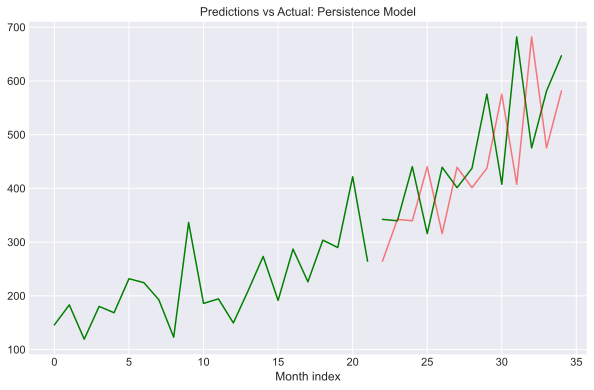

In [18]:
fig, axis = plt.subplots(figsize = (10,6))

axis.plot(y_train, color = 'green')
axis.plot([None for i in y_train]+ [x for x in y_test], color = 'green')
axis.plot([None for i in y_train]+ [x for x in fc_predictions], color = 'red', alpha = 0.5)

axis.set_xlabel('Month index')
axis.set_title('Predictions vs Actual: Persistence Model')

axis.grid()

We have seen an example of the persistence model developed from scratch for the Shampoo Sales problem. The persistence algorithm is naive. It is often called the naive forecast. It assumes nothing about the specifics of the time series problem to which it is applied. This is what makes it so easy to understand and so quick to implement and evaluate. As a machine learning practitioner, it can also spark a large number of improvements. Write them down. This is useful because these ideas can become input features in a feature engineering effort or simple models that may be combined in an ensembling effort later.

---
## CH19: Visualize Residual Forecast Errors
---

Forecast errors on time series regression problems are called residuals or residual errors. Careful exploration of residual errors on your time series prediction problem can tell you a lot about your forecast model and even suggest improvements. In this tutorial, you will discover how to visualize residual errors from time series forecasts. After completing this tutorial, you will know:

- How to create and review line plots of residual errors over time.
- How to review summary statistics and plots of the distribution of residual plots. 
- How to explore the correlation structure of residual errors.

Let’s get started.

### Residual Forecast Errors: 

Forecast errors on a time series forecasting problem are called residual errors or residuals. A residual error is calculated as the expected outcome minus the forecast, for example:

$$ \textrm{residual error} = \textrm{expected} - \textrm{forecast} $$

Or, more succinctly and using standard terms as:

$$ e = y-\hat{y}$$

We often stop there and summarize the skill of a model as a summary of this error. Instead, we can collect these individual residual errors across all forecasts and use them to better understand the forecast model. Generally, when exploring residual errors we are looking for patterns or structure. A sign of a pattern suggests that the errors are not random.

We expect the residual errors to be random, because it means that the model has captured all of the structure and the only error left is the random fluctuations in the time series that cannot be modeled. A sign of a pattern or structure suggests that there is more information that a model could capture and use to make better predictions.

Before we start exploring the different ways to look for patterns in residual errors, we need context. In the next section, we will look at a dataset and a simple forecast method that we will use to generate residual errors to explore in this tutorial.

In this lesson, we will use the Daily Female Births Dataset as an example. This dataset describes the number of daily female births in California in 1959.

In [19]:
df = pd.read_csv('daily-total-female-births.csv', index_col=0, header = 0, parse_dates=True)

df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


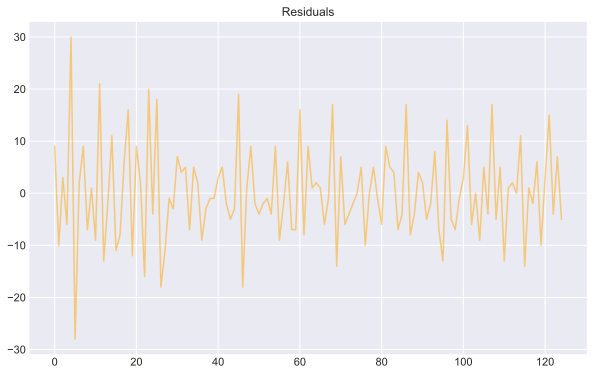

In [20]:
# We will repeat the steps from Chapter 18 to build a persistence model and get predictions to obtain residuals 

series = df.squeeze('columns')
lag1_series = series.shift(1)
df_fb = pd.concat([lag1_series,series],axis = 1)

# train-test split 

X = df_fb.values 
train_split = int(len(X)*0.66)

train, test = X[1:train_split], X[train_split:]
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

# Predictions according to the persistence model 

predictions = [x for x in X_test] # Recall that the naive forecast assigns the predictions as the previous values of the target

# Residuals 

residuals = [y_test[i] - predictions[i] for i in range(len(predictions))] 

# plot residuals 

fig, axis = plt.subplots(figsize = (10,6))

axis.plot(residuals, color= 'orange', alpha = 0.5)


axis.set_title('Residuals')
axis.grid()

The first plot is to look at the residual forecast errors over time as a line plot. We would expect the plot to be random around the value of 0 and not show any trend or cyclic structure. Running the example shows a seemingly random plot of the residual time series. If we did see trend, seasonal or cyclic structure, we could go back to our model and attempt to capture those elements directly. 

Next, we look at summary statistics that we can use to see how the errors are spread around zero.

### Residual Summary Statistics:

We can calculate summary statistics on the residual errors. Primarily, we are interested in the mean value of the residual errors. A value close to zero suggests no bias in the forecasts, whereas positive and negative values suggest a positive or negative bias in the forecasts made. It is useful to know about a bias in the forecasts as it can be directly corrected in forecasts prior to their use or evaluation.
Below is an example of calculating summary statistics of the distribution of residual errors. This includes the mean and standard deviation of the distribution, as well as percentiles and the minimum and maximum errors observed.

In [21]:
residuals_df = pd.DataFrame(residuals)

residuals_df.describe()

,0
count,125.000000
mean,0.064000
std,9.187776
min,-28.000000
25%,-6.000000
50%,-1.000000
75%,5.000000
max,30.000000


Running the example shows a mean error value close to zero, but perhaps not close enough. It suggests that there may be some bias and that we may be able to further improve the model by performing a bias correction. This could be done by adding the mean residual error (0.064000) to forecasts. This may work in this case, but it is a naive form of bias correction and there are more sophisticated methods available.

Next, we go beyond summary statistics and look at methods to visualize the distribution of
the residual errors.

### Residual Histogram and Density Plots:

Plots can be used to better understand the distribution of errors beyond summary statistics. We would expect the forecast errors to be normally distributed around a zero mean. Plots can help discover skews in this distribution. We can use both histograms and density plots to better understand the distribution of residual errors. Below is an example of creating one of each plot.

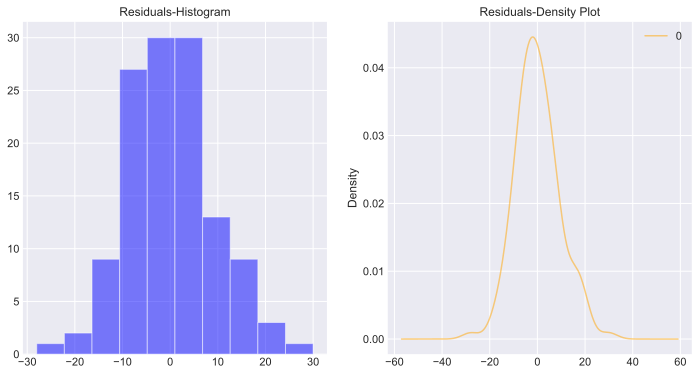

In [22]:
fig, axis = plt.subplots(1,2,figsize = (12,6))

axis[0].hist(residuals_df, color= 'blue', alpha = 0.5)
residuals_df.plot(kind = 'kde', color= 'orange', alpha = 0.5, ax=axis[1])

axis[0].set_title('Residuals-Histogram')
axis[1].set_title('Residuals-Density Plot')

axis[0].grid()
axis[1].grid()

We can see that the distribution does have a Gaussian look, but is perhaps more pointy, showing an exponential distribution with some asymmetry. If the plot showed a distribution that was distinctly non-Gaussian, it would suggest that assumptions made by the modeling process were perhaps incorrect and that a different modeling method may be required. A large skew may suggest the opportunity for performing a transform to the data prior to modeling, such as taking the log or square root.


Next, we will look at another quick, and perhaps more reliable, way to check if the distribution of residuals is Gaussian.

### Residual Q-Q Plot:

A Q-Q plot, or quantile plot, compares two distributions and can be used to see how similar or different they happen to be. We can create a Q-Q plot using the `qqplot()` function in the Statsmodels library.

The Q-Q plot can be used to quickly check the normality of the distribution of residual errors. The values are ordered and compared to an idealized Gaussian distribution. The comparison is shown as a scatter plot (theoretical on the x-axis and observed on the y-axis) where a match between the two distributions is shown as a diagonal line from the bottom left to the top-right of the plot.

The plot is helpful to spot obvious departures from this expectation. Below is an example of a Q-Q plot of the residual errors. The x-axis shows the theoretical quantiles and the y-axis shows the sample quantiles.

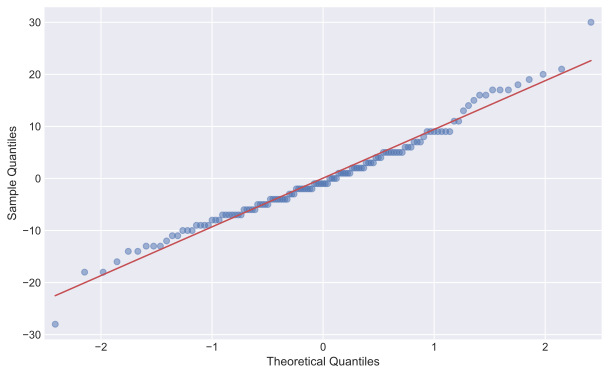

In [23]:
from statsmodels.graphics.gofplots import qqplot

fig, axis = plt.subplots(figsize = (10,6))

qq_plot = qqplot(np.array(residuals),line = 'r', alpha = 0.5, ax=axis)

axis.grid()

Running the example shows a Q-Q plot that the distribution is seemingly normal with a few bumps and outliers.

Next, we can check for correlations between the errors over time.

### Residual Autocorrelation Plot: 

Autocorrelation calculates the strength of the relationship between an observation and observa- tions at prior time steps. We can calculate the autocorrelation of the residual error time series and plot the results. This is called an autocorrelation plot. We would not expect there to be any correlation between the residuals. This would be shown by autocorrelation scores being below the threshold of significance (dashed and dotted horizontal lines on the plot).

A significant autocorrelation in the residual plot suggests that the model could be doing a better job of incorporating the relationship between observations and lagged observations, called autoregression. Pandas provides a built-in function for calculating an autocorrelation plot, called `autocorrelation_plot()`.

Below is an example of visualizing the autocorrelation for the residual errors. The x-axis shows the lag and the y-axis shows the correlation between an observation and the lag variable, where correlation values are between -1 and 1 for negative and positive correlations respectively.

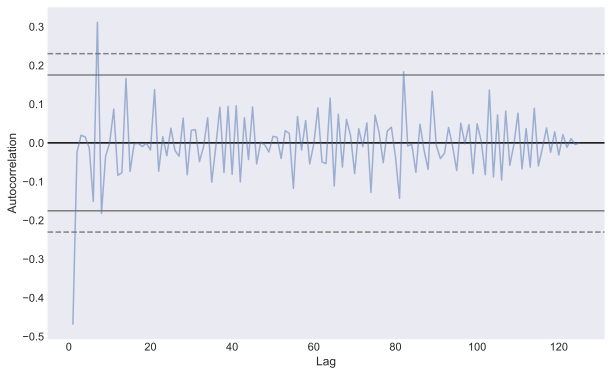

In [24]:
from pandas.plotting import autocorrelation_plot

fig, axis = plt.subplots(figsize = (10,6))

auto_plot = autocorrelation_plot(np.array(residuals), alpha = 0.5, ax=axis)

axis.grid()

Running the example creates an autoregression plot of other residual errors. We do not see an obvious autocorrelation trend across the plot. There may be some positive autocorrelation worthy of further investigation at lag 7 that seems significant.

---
## CH20: Reframe Time Series Forecasting Problems
---

You do not have to model your time series forecast problem as-is. There are many ways to reframe your forecast problem that can both simplify the prediction problem and potentially expose more or different information to be modeled. A reframing can ultimately result in better and/or more robust forecasts. In this tutorial, you will discover how to reframe your time series forecast problem with Python. After completing this tutorial, you will know:

- How to reframe your time series forecast problem as an alternate regression problem.
- How to reframe your time series forecast problem as a classification prediction problem. 
- How to reframe your time series forecast problem with an alternate time horizon.

Let’s get started.

### Benefits of Reframing Your Problem:

Reframing your problem is the idea of exploring alternate perspectives on what is to be predicted. There are two potential benefits to exploring alternate framings of your time series forecast problem:

1. Simplify your problem.
2. Provide the basis for an ensemble forecast.

Both benefits ultimately have the result of leading to more skillful and/or more robust forecasts.

#### Simplify Your Problem

Perhaps the largest wins on a forecasting project can come from a reframing of the problem. This is because the structure and type of prediction problem has so much more impact than the choice of data transforms, choice of model, or the choice of model hyperparameters. It is the biggest lever in a project and must be carefully considered.

#### Ensemble Forecast

In addition to changing the problem you are working on, reframing plays another role: it can provide you with a suite of different, but highly related problems that you can model. The benefit of this is that the framings may be different enough to require differences in data preparation and modeling methods.
Models of differing perspectives on the same problem may capture different information from the input and in turn result in predictions that are skillful, but in different ways. These predictions may be combined in an ensemble to result in a more skillful or more robust forecast. In this tutorial, we will explore three different ways you may consider reframing your time series forecast problem. Before we dive in, let’s look at a simple univariate time series problem of forecasting the minimum daily temperature to use as context for the discussion.

In this lesson, we will use the Minimum Daily Temperatures dataset as an example. This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.

In [25]:
df = pd.read_csv('daily-min-temperatures.csv', index_col = 0, header = 0, parse_dates = True)

df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


### Naive Time Series Forecast

The naive approach is to predict the problem as-is. For reference, we will call this the naive time series forecast. In this case, the seasonal information can be removed to make the series seasonal stationary. The time series can then be modeled based on some function of the lagged observations. For example:

$$ \textrm{Temp}(t+1)=B_0+(B_1\times \textrm{Temp}(t))+(B_2\times \textrm{Temp}(t−1)) + ...  (B_n \times \textrm{Temp}(t−n)) $$

Where `Temp(t+1)` is the next temperature in the series to predict, $B_0$ to $B_n$ are coefficients learned from training data and `Temp(t)` to `Temp(t-n)` are the current and lagged observations. This may be fine or even required by many problems. The risk is that a preconceived idea of how to frame the problem has influenced data collection, and in turn perhaps limited the results.

### Regression Framings

Most time series prediction problems are regression problems, requiring the prediction of a real-valued output. Below are 5 different ways that this prediction problem could be re-phrased as an alternate regression problem:

- Forecast the change in the minimum temperature compared to the previous day.
- Forecast the minimum temperature relative to the average from the past 14 days.
- Forecast the minimum temperature relative to the average the same month last year.
- Forecast the minimum temperature rounded to the nearest 5 degrees Celsius.
- Forecast the average minimum temperature for the next 7 days.

Making the temperature relative is a linear transform and may not make the problem simpler and easier to predict, but it may shake loose new ideas or even new sources of data that you may consider. It also may help you think more clearly about how exactly the forecast will be used and what the hard requirements on that forecasted value actually are.

Transforming the granularity of a prediction problem does change the difficulty of the problem and can be very useful if the requirements of the problem permit such redefinitions. Below is an example of reframing the Minimum Daily Temperatures forecast problem to predict the daily temperature rounded to the nearest 5 degrees.

In [26]:
# Create a lagged df 

series = df.squeeze('columns')

lag1_series = series.shift(1)

df_mt = pd.concat([lag1_series,series], axis = 1)

df_mt.columns = ['t', 't+1']

# Round the target to the nearest multiple of 5 

for i in range(len(df_mt['t+1'])):

    df_mt['t+1'][i] = int(df_mt['t+1'][i]/5) * 5.0

df_mt.head()

,t,t+1
Date,,
1981-01-01,NaN,20.0
1981-01-02,20.7,15.0
1981-01-03,17.9,15.0
1981-01-04,18.8,10.0
1981-01-05,14.6,15.0


### Classification Framings

Classification involves predicting categorical or label outputs (like hot and cold). Below are 5 different ways that this prediction problem can be rephrased as a classification problem:

- Forecast whether a minimum temperature will be cold, moderate, or warm. 
- Forecast whether a change in minimum temperature will be small or large.
- Forecast whether the minimum temperature will be a monthly minimum or not.
- Forecast whether the minimum will be higher or lower than the minimum in the previous year.
- Forecast whether the minimum temperature will rise or fall over the next 7 days.

A move to classification can simplify the prediction problem. This approach opens up ideas on labels as well as binary classification framings.
The native regression representation of the output variable means that most classification framings are likely to keep the ordinal structure (e.g. cold, moderate, hot). Meaning that there is an ordered relationship between the classes being predicted, which may not be the case when predicting labels like dog and cat.

The ordinal relationship permits both a hard classification problem as well as an integer prediction problem that can be post-hoc rounded into a specific category. Below is an example of transforming the Minimum Daily Temperatures forecast problem to a classification problem where each temperature value is an ordinal value of cold, moderate, or hot. These labels are mapped to integer values, defined as:

- `0 (cold)`: < 10 degrees Celsius.
- `1 (moderate)`: ≥ 10 and < 25 degrees Celsius. 
- `2 (hot)`: ≥ 25 degrees Celsius.


In [27]:
# Create a lagged df 

series = df.squeeze('columns')

lag1_series = series.shift(1)

df_mt = pd.concat([lag1_series,series], axis = 1)

df_mt.columns = ['t', 't+1']

# Re-label the target 
for i in range(len(df_mt['t+1'])):

    temp = df_mt['t+1'][i]

    if temp < 10.0:

        df_mt['t+1'][i] = 0
    
    elif temp >= 25.0:

        df_mt['t+1'][i] = 2
    
    else:

        df_mt['t+1'][i] = 1

df_mt.head()

,t,t+1
Date,,
1981-01-01,NaN,1.0
1981-01-02,20.7,1.0
1981-01-03,17.9,1.0
1981-01-04,18.8,1.0
1981-01-05,14.6,1.0


### Time Horizon Framings

Another axis that can be varied is the time horizon. The time horizon is the number of time steps in the future that are being predicted. Below are 5 different ways that this prediction problem can be re-phrased as a different time horizon:

- Forecast the minimum temperature for the next 7 days.
- Forecast the minimum temperature in 30 days time.
- Forecast the average minimum temperature next month.
- Forecast the day in the next week that will have the lowest minimum temperature. 
- Forecast one year of minimum temperature values.

It is easy to get caught up in the idea that you require one-step forecasts. Focusing on reframings of the problem around time horizon forces you to think about point versus multi-step forecasts and how far in the future to consider.

You may be able to forecast far into the future, but the skill is likely going to vary, degrading further into the future you project. When thinking through the horizon of the forecast, also consider the minimum acceptable performance of forecasts. The example below transforms the Minimum Daily Temperatures forecast problem to predict the minimum temperature for the next 7 days.

In [28]:
# Create a lagged df: given the minimum temperature from the day before, forecast the minimul daily temperature for the next 7 days 

series = df.squeeze('columns')

df_mt = pd.concat([series.shift(1),series, series.shift(-1),series.shift(-2),series.shift(-3),series.shift(-4),series.shift(-5),series.shift(-6)], axis = 1)

df_mt.columns = ['t', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6', 't+7']


df_mt.head()

,t,t+1,t+2,t+3,t+4,t+5,t+6,t+7
Date,,,,,,,,
1981-01-01,NaN,20.7,17.9,18.8,14.6,15.8,15.8,15.8
1981-01-02,20.7,17.9,18.8,14.6,15.8,15.8,15.8,17.4
1981-01-03,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8
1981-01-04,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0
1981-01-05,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2
